# **Combination VSM and BM25 Search Engine**
Alain Ameer, Alexander Coudijzer, Bradley Aldous and Florin Pintilii.

# Contents
1. Introduction
1. Data Loading
1. Indexing Method
  - Pre-Processing
  - Term-Frequency Matrix
1. Retrieval Method
  - Query Vectorization and Vocabularization
  - Vector Space Model (VSM)
    - VSM: TF-IDF Matrix
    - VSM: Scoring (Cosine Similarity)
  - Best Match 25 (BM25)
1. Evaluation
1. Command Line Implementation
  - Query Example 1
  - Query Example 2
  - Query Example 3
  - Query Example 4: Custom Query
1. Bibliography

# Introduction

This engine enables users to enter a query and select whether VSM or BM25 is used as the model to return search results. SciFact is used as the dataset (MacAvaney et al, 2021).

All relevant libraries are imported and datasets installed in the code cell below. The nltk library has been sourced from Bird and colleagues (2009).

In [1]:
%%capture
!pip install ir_datasets
!pip install unidecode

import numpy as np
import ir_datasets
import string
import re
import unidecode
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ndcg_score
from operator import itemgetter

import nltk             # nltk has been sourced from (Bird et al, 2009).
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

# Data Loading

The characteristics of SciFact are displayed by the code cell below. There are 5183 documents, 809 associated queries, and 919 query relevance judgements ("qrels").

In [2]:
dataset = ir_datasets.load("beir/scifact/train")

print('\n', dataset.docs_count(), 'documents with format:\n\t', 
      dataset.docs_cls().__annotations__)
print('\n', dataset.queries_count(), 'queries with format:\n\t', 
      dataset.queries_cls().__annotations__)
print('\n', dataset.qrels_count(), 'query relevance judgements with format:\n\t', 
      dataset.qrels_cls().__annotations__)


 5183 documents with format:
	 OrderedDict([('doc_id', <class 'str'>), ('text', <class 'str'>), ('title', <class 'str'>)])

 809 queries with format:
	 OrderedDict([('query_id', <class 'str'>), ('text', <class 'str'>)])

 919 query relevance judgements with format:
	 OrderedDict([('query_id', <class 'str'>), ('doc_id', <class 'str'>), ('relevance', <class 'int'>), ('iteration', <class 'str'>)])


The code cell below loads the data.

In [3]:
%%capture
for doc in dataset.docs_iter()[:1]: None
for q in dataset.queries_iter(): None
for qrel in dataset.qrels_iter(): None

The text of the documents have been collected into a list variable `documents` in the code cell below. The text alone has been taken for simplicity at this stage, however the `doc_id` will later be required for evaluation.

In [4]:
corpus = []
for doc in dataset.docs_iter():
    corpus.append([doc[0],doc[1],doc[2]])
documents = [doc[1] for doc in corpus]

print('\nNumber of documents: ' + str(len(documents))
      + '\n\nExample documents: "' + documents[0][:50] + '..."'
      + '\n\t\t   "' + documents[1][:50] + '..."'
      + '\n\t\t   "' + documents[2][:50] + '..."')


Number of documents: 5183

Example documents: "Alterations of the architecture of cerebral white ..."
		   "Myelodysplastic syndromes (MDS) are age-dependent ..."
		   "ID elements are short interspersed elements (SINEs..."


The text of the queries have likewise been collected into a list variable `queries` in the code cell below.

In [5]:
queries = []
for q in dataset.queries_iter():
    queries.append(q[1])
    
print('\nNumber of queries: ' + str(len(queries))
      + '\n\nExample queries: "' + queries[0][:50] + '..."'
      + '\n\t\t "' + queries[1][:50] + '..."'
      + '\n\t\t "' + queries[2][:50] + '..."')


Number of queries: 809

Example queries: "0-dimensional biomaterials lack inductive properti..."
		 "1 in 5 million in UK have abnormal PrP positivity...."
		 "1-1% of colorectal cancer patients are diagnosed w..."


# Indexing Method

### _Indexing Method: Pre-Processing_

The first stage of the indexing method is to pre-process text.

The code cell below defines the `pre_processing` function. The following stages are applied to the text of each document:

[A] Text is cleaned.
  1. Numbers are removed.
  1. Punctuation is removed and characters are converted to lowercase.
  1. Multiple whitespaces are replaced with single whitespaces. Leading and training whitespaces are also removed.

[B] Tokenization.

[C] Stop word removal.

[D] Lemmatization.

[E] Stemming.

[F] Accents are removed.

In [6]:
def pre_processing(docs):
    
    # [A] A function to clean text is defined.
    def clean_text(text):
        # [1] Numbers are removed.
        text_nonum = re.sub(r'\d+', '', text) 
        # [2] Punctuation is removed and characters converted to lowercase.
        text_nopunct = "".join([char.lower() for char in text_nonum
                                if char not in string.punctuation])
        # [3] Multiple whitespaces are replaced with single whitespaces.
        #     Leading and trailing whitespaces are removed.
        text_no_multispace = re.sub('\s+', ' ', text_nopunct).strip()
        return text_no_multispace
    
    # [A] Each document is passed through the "clean_text" function.
    documents_cleaned = []
    for d in docs:
        x = clean_text(d)
        documents_cleaned.append(x)
    
    # [B] Each document is tokenized.
    documents_tokenized = []
    for d in documents_cleaned:
        x = word_tokenize(d)
        documents_tokenized.append(x)
    
    # [C] Each document has stop words removed.
    documents_sw_removed = []
    stop_words = set(stopwords.words('english'))
    for a in documents_tokenized:
        filtered_sentence = [w for w in a if not w in stop_words]
        filtered_sentence = []
        for w in a:  
            if w not in stop_words:  
                filtered_sentence.append(w)
        documents_sw_removed.append(filtered_sentence)
    
    # [D] Each document undergoes lemmatization.
    documents_lemmatized = []
    wordnet_lemmatizer = WordNetLemmatizer()
    for d in documents_sw_removed:
        y = []
        for word in d:
            x = wordnet_lemmatizer.lemmatize(word)
            y.append(x)
        documents_lemmatized.append(y)
    
    # [E] Each document undergoes stemming.
    snow_stemmer = SnowballStemmer(language='english')
    documents_stemmed = []
    for d in documents_lemmatized:
        stems = []
        for word in d:
            x = snow_stemmer.stem(word)
            stems.append(x)
        documents_stemmed.append(stems)
    
    # [F] Accents are removed from each document.
    documents_decoded = []
    for d in documents_stemmed:
        a = []
        for word in d:
            x = unidecode.unidecode(word)
            a.append(x)
        documents_decoded.append(a)
    
    # [G] Processed documents are collected into "documents_pre_processed"
    documents_pre_processed = []
    for doc in documents_decoded:
        documents_pre_processed.append(' '.join(doc))
    return documents_pre_processed

The code cell below applies the previously defined `pre_processing` function to both the documents and the queries. Both documents and queries need to be pre-processed in the same way to ensure compatability.

In [7]:
documents_pre_processed = pre_processing(documents)
queries_pre_processed = pre_processing(queries)

The code cell below demonstrates the results of applying the `pre_processing` function.

In [8]:
print('\nDocument prior to pre-processing:\n' + '\t"' + documents[0][:97]
      + '..."\n\nDocument after pre-processing has been performed:\n'
      + '\t"' + documents_pre_processed[0][:64] + '..."\n\n'
      + 'Query prior to pre-processing:\n' + '\t"' + queries[0] + '"\n\n'
      + 'Query after pre-processing has been performed:\n'
      + '\t"' + queries_pre_processed[0] + '"')


Document prior to pre-processing:
	"Alterations of the architecture of cerebral white matter in the developing human brain can affect..."

Document after pre-processing has been performed:
	"alter architectur cerebr white matter develop human brain affect..."

Query prior to pre-processing:
	"0-dimensional biomaterials lack inductive properties."

Query after pre-processing has been performed:
	"dimension biomateri lack induct properti"


### _Indexing Method: Term-Frequency Matrix_

The pre-processed documents are vectorised in the code cell below to create a term-frequency (TF) matrix, `term_frequency_matrix`, which is a pandas dataframe:

- Each row represents a document and each column represents a term in the corpus.
- The columns collectively represent the vocabulary of the entire corpus.
- Each cell represents the frequency with which the term of the column occurs in the document of the row.

The TF matrix is subsequently used by both the VSM and BM25 retrieval models:



> **VSM:** The TF matrix is multiplied by the inverse document frequency (IDF).

> **BM25:** The TF matrix is adjusted for both document length normalisation and IDF.




  
 

In [9]:
vectorizer = CountVectorizer()
documents_vectorized = vectorizer.fit_transform(documents_pre_processed).toarray()
vocabulary = vectorizer.get_feature_names_out()

term_frequency_matrix = pd.DataFrame(documents_vectorized, columns = vocabulary)
term_frequency_matrix

,42,aa,aaa,aaaatpas,aaafamili,aab,aabenhus,aacr,aacrthi,aactinin,...,zygos,zygot,zymographi,zymosan,zymosaninduc,zyxin,zz,zzw,zzz,zzzw
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5178,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5180,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5181,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Retrieval Method

### _Retrieval Method: Query Vectorization and Vocabularization_

The code cell below retrieves the query ID numbers. These IDs are combined with the respective query text that has previously been pre-processed, into the list variable `queries`.

In [10]:
qid = []
for q in dataset.queries_iter():
    qid.append(q[0])
qid = [eval(x) for x in qid]  # Reading in query IDs and converting to int
queries_dict = dict(zip(qid, queries))
queries = [list(a) for a in zip(qid, queries_pre_processed)]

print('\nNumber of queries with ID: ' + str(len(queries))
      + '\n\nExample queries with ID: ' + str(queries[0])
      + '\n\t\t\t ' + str(queries[1])
      + '\n\t\t\t ' + str(queries[2]))


Number of queries with ID: 809

Example queries with ID: [0, 'dimension biomateri lack induct properti']
			 [2, 'million uk abnorm prp posit']
			 [4, 'colorect cancer patient diagnos region distant metastasi']


The code cell below likewise retrieves the document ID numbers. These IDs are combined with the respective document text that has previously been pre-processed, into the list variable `documents_id`.

In [11]:
documents_id = []
for doc in corpus:
    documents_id.append([doc[0],doc[1]])

print('\nNumber of documents with ID: ' + str(len(documents_id))
      + '\n\nExample documents with ID: ' + str(documents_id[0])[:50] + "...']"
      + '\n\t\t\t   ' + str(documents_id[1])[:50] + "...']"
      + '\n\t\t\t   ' + str(documents_id[2])[:50] + "...']")


Number of documents with ID: 5183

Example documents with ID: ['4983', 'Alterations of the architecture of cereb...']
			   ['5836', 'Myelodysplastic syndromes (MDS) are age-...']
			   ['7912', "ID elements are short interspersed eleme...']


The code cell below sets the query ID number `query_id_num` to be tested. The query is subsequently retreived into the variable `query_to_be_tested`.

In [12]:
query_id_num = 2

In [13]:
query_to_be_tested = [x for x in queries if x[0] == query_id_num][0][1]

A function `query_vectorizer_vocabularizer` is defined in the code cell below which performs the following:

- The vocabulary `q_vocabulary` of the query to be tested is obtained.
- The query is converted into a term vector `q_tf_vector`.

The term vector has  same number of elements as columns of `term_frequency_matrix` (31075 terms). The elements are 0 when the term is absent and 1 when it is present.

> **VSM:** Utilises `q_tf_vector` as the query representation, multiplying by IDF.

> **BM25:** Utilises `q_vocabulary` to identify which term weights to sum for scoring.

In [14]:
def query_vectorizer_vocabularizer(query_to_be_vectorized):

    q_vectorizer = CountVectorizer()
    q = q_vectorizer.fit_transform([query_to_be_vectorized])
    q_vocabulary = q_vectorizer.get_feature_names_out()
  
    print('\t   Vocabulary: ' + str(q_vocabulary) + '')

    q_tf_vector = np.array([])
    for t in term_frequency_matrix.columns:
        if t in q_vocabulary: q_tf_vector = np.append(q_tf_vector,1)
        else: q_tf_vector = np.append(q_tf_vector,0)

    print('Term-Frequency Vector: ' + str(q_tf_vector) + '' 
          + ' (Sum = ' + str(round(q_tf_vector.sum(),2)) 
          + ', Length = ' + str(len(q_tf_vector)) + ')')
  
    return q_tf_vector, q_vocabulary

The previously defined `query_vectorizer_vocabularizer` function is run below for the query to be tested, and returns the variables `q_vocabulary` and `q_tf_vector`.

In [15]:
print('  Pre-Processed Query: "' + str(query_to_be_tested) + '"')
q_tf_vector, q_vocabulary = query_vectorizer_vocabularizer(query_to_be_tested)

  Pre-Processed Query: "million uk abnorm prp posit"
	   Vocabulary: ['abnorm' 'million' 'posit' 'prp' 'uk']
Term-Frequency Vector: [0. 0. 0. ... 0. 0. 0.] (Sum = 5.0, Length = 31075)


### _Retrieval Method: Vector Space Model (VSM)_

#### **VSM: TF-IDF Matrix**

The Inverse Document Frequency (IDF) must be calculated for the VSM model in the code cell below:

- `dfs` is a pandas series representing document frequency. There are 31075 values corresponding to each term in the vocabulary of the corpus. Each value represents the number of documents that contain that term.
- `N` is an integer representing the total number of documents in the corpus (5183).
- `idfs` is the inverse document frequency (IDF). It is also a pandas series of the same shape as dfs (31075 rows). It is calculated by taking the $log_{10}$ of the result of dividing the number of documents by document frequency ($log_{10}(N/dfs)$).

All the elements of `term_frequency_matrix` are multiplied by the `idfs` in the subsequent code cell, to obtain a TF-IDF matrix `tf_idf_matrix`.

In [16]:
dfs = (term_frequency_matrix > 0).sum(axis = 0) # Document frequency.
N = term_frequency_matrix.shape[0] # Total number of documents.
idfs = np.log10(N/dfs) # Inverse Document Frequency (IDF).
print("\nidfs:\n\n" + str(idfs))


idfs:

42           3.714581
aa           2.600638
aaa          3.112521
aaaatpas     3.237460
aaafamili    3.714581
               ...   
zyxin        3.714581
zz           3.714581
zzw          3.714581
zzz          3.714581
zzzw         3.714581
Length: 31075, dtype: float64


In [17]:
tf_idf_matrix = np.array(term_frequency_matrix * idfs) # TF-IDF matrix.

print("\ntf_idf_matrix:\n\n" + str(tf_idf_matrix))
print(str(tf_idf_matrix.shape[0]) + " rows by " + str(tf_idf_matrix.shape[1]) + " columns.")
print("\nThe sum of all elements in tf_idf_matrix is " + str(int(tf_idf_matrix.sum().sum()))
      + ", \nwhich is up from " + str(term_frequency_matrix.sum().sum())
      + " for term_frequency_matrix.")


tf_idf_matrix:

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
5183 rows by 31075 columns.

The sum of all elements in tf_idf_matrix is 1044106, 
which is up from 643219 for term_frequency_matrix.


#### **VSM: Scoring (Cosine Similarity)**

As with the `term_frequency_matrix`, the TF vector `q_tf_vector` defined during indexing likewise needs to be multiplied by the IDF, to obtain a TF-IDF vector `q_tf_idf_vector`. The sum of this vector as displayed below is now 9.6 rather than 5 for the number of terms it contains. A VSM function is defined to perform this operation.

The VSM function subsequently calculates the cosine similarity between:

- The document vectors of TF-IDF weights, stored in `tf_idf_matrix`, 
- and the query vector of TF-IDF weights `q_tf_idf_vector`.

The cosine similarity is calculated by dividing the dot product of the two vectors by the product of their Euclidean normalisation

When run in the subsequent code cell, the `VSM` function returns the list variable scores, which has 5183 elements corresponding to the number of documents in the corpus.

In [18]:
def VSM(q_tf_vector): # Calculations inferred from Baeza-Yates and Ribeiro-Neto (2011).

    q_tf_idf_vector = (q_tf_vector * idfs).values
    print('  Query TF-IDF Vector: ' + str(q_tf_idf_vector) 
          + ' (Sum = ' + str(round(q_tf_idf_vector.sum(), 2)) 
          + ', Length = ' + str(len(q_tf_idf_vector)) + ')')

    VSM_scores = []
    for d in tf_idf_matrix:
        VSM_scores.append(np.dot(d, q_tf_idf_vector)/(norm(d)*norm(q_tf_idf_vector)))

    return VSM_scores

In [19]:
scores = VSM(q_tf_vector)

scores_string = ''
for s in scores[100:103]:
    scores_string += str(s) + ', '
print('    "scores" variable: [...' + scores_string 
      + '...] (Sum = ' + str(round(sum(scores), 2)) 
      + ', Length = ' + str(len(scores)) + ')')

  Query TF-IDF Vector: [0. 0. 0. ... 0. 0. 0.] (Sum = 9.61, Length = 31075)
    "scores" variable: [...0.0, 0.0, 0.0, ...] (Sum = 13.62, Length = 5183)


A function is defined in the code cell below to display a table. The table contains the document ID, document text and retrieval score for each document. The documents are sorted in descending retrieval scores, such that the most similar documents to the query are at the top of the table.

In [20]:
def display_ranking(top_n, scores, score_type):

    documents_scored = []

    for (d,n,s) in zip(documents_id, range(len(documents_id)), scores):
        documents_scored.append([])
        documents_scored[n].append(int(d[0]))
        documents_scored[n].append(d[1])
        documents_scored[n].append(s)

    documents_scored = sorted(documents_scored, # Sort by descending score.
                              key = itemgetter(2), reverse = True)

    documents_scored = pd.DataFrame(documents_scored, 
                                    columns = ['Doc_ID', 
                                               'Text', 
                                               score_type + " Score"]).set_index('Doc_ID')

    documents_scored.insert(0, 'Rank', range(1, 1 + len(documents_scored)))

    return documents_scored.head(top_n)

The previously defined `display_ranking` function is called in the code cell below, to display the top 10 documents.

In [21]:
display_ranking(10, scores, "VSM")

,Rank,Text,VSM Score
Doc_ID,,,
13734012,1,OBJECTIVES To carry out a further survey of ar...,0.364472
26059876,2,"Ku70, a known nonhomologous end-joining (NHEJ)...",0.352551
13770184,3,"BACKGROUND The Global Burden of Diseases, Inju...",0.238112
3716075,4,BACKGROUND Dengue is the most common arbovirus...,0.168597
14610165,5,Antisense transcription is widespread in many ...,0.128051
23531592,6,By the year 2000 there will be six million pre...,0.109300
11880289,7,BACKGROUND Age-specific effects of mammographi...,0.108722
11936877,8,Soil erosion is a major environmental threat t...,0.095828
841371,9,OBJECTIVE To assess the robustness of patient ...,0.090755


### _Retrieval Method: Best Match 25 (BM25)_

Variables are first defined that will be used by the BM25 retrieval model:

- `dls` is a list containing document lengths for each document indexed in the `term_frequency_matrix`. The length has been calculated by summing over columns in the `term_frequency_matrix`, which has the benefit of ignoring stop words that have been  removed by `pre_processing`.

- `avgdl` represents average document length, calculated as mean of `dls`.

- Grid-search optimization has been performed for the TF saturation `k_1` and document length normalization `b` hyperparameters. The values $[0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2]$ and $[0.4, 0.8, 1.2, 1.6]$ have been tested respectively. Normalized Discounted Cumulative Gain (NDCG) has been used as the evaluation metric. Optimal values are $2.0$ and $0.8$ respectively. The results of this optimization are displayed in the code cell below.

The optimized BM25 model outperforms the VSM model, with a NDCG@10 of 0.662 compared to 0.572 respectively.

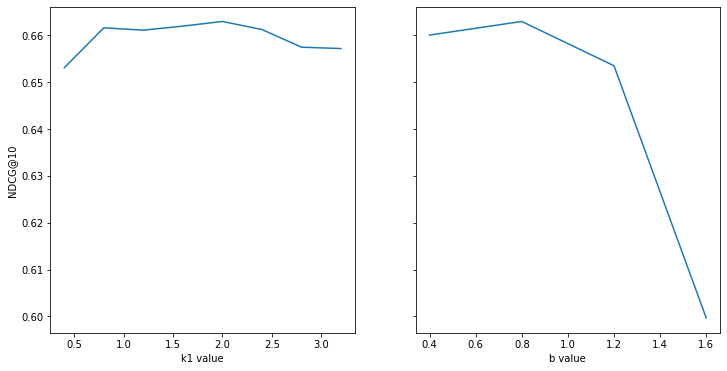

In [22]:
k_1_all = [0.4, 0.8, 1.2, 1.6, 2, 2.4, 2.8, 3.2]; b_all = [0.4, 0.8, 1.2, 1.6]
k_1_results = [0.6530751796252287, 0.661582975249405, 0.6610855944825611, 0.6619520881719833, 
               0.662944606152911, 0.661228957293065, 0.6574596514179312, 0.6571591894257656]
b_results = [0.6600409197366047, 0.662944606152911, 0.6534918165442308, 0.5996544851456663]
 
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6), sharey = True)
ax1.plot(k_1_all, k_1_results); ax1.set_ylabel('NDCG@10')
ax1.set_xlabel('k1 value'); ax2.plot(b_all, b_results)
ax2.set_xlabel('b value'); plt.show()

The numerator of BM25 weights is calculated by multiplying the TF weights in  `term_frequency_matrix` by the result of adding 1 to `k_1`:
> $TF * (k_1 + 1)$

The denominator is calculated by a formula which normalizes for document length:
> $TF + (k_1 * (1 - b + (b * (dls/avgdl))))$

The result of dividing the numerator by the denominator is multiplied by the `idfs`.

The resulting BM25 weights are collected in the matrix `BM25_matrix`, displayed below.


In [23]:
k_1 = 2   # Grid search optimized hyperparameter.   # Code in this cell has been 
b = 0.8   # Grid search optimized hyperparameter.   # adapted from QMUL (2022a).
dls = term_frequency_matrix.sum(axis=1).tolist() # Document length.
avgdl = np.mean(dls) # Mean document length.

# Applying the BM25 formula:
numerator = np.array(term_frequency_matrix * (k_1 + 1))
denominator = np.array(term_frequency_matrix) \
              + np.array(k_1 * ((1 - b) + (b * (dls / avgdl)))).reshape(N,1)
BM25_matrix = (numerator / denominator) * np.array(idfs)
BM25_matrix = pd.DataFrame(BM25_matrix, columns = vocabulary)

In [24]:
print("\nBM25_matrix (first 5 rows and 5 columns):\n\n" + str(BM25_matrix.iloc[:5,:5]))
print(str(BM25_matrix.shape[0]) + " rows by " + str(BM25_matrix.shape[1]) + " columns.")
print("\nThe sum of all elements in BM25_matrix is " + str(int(BM25_matrix.sum().sum()))
      + ", \nwhich is up from " + str(term_frequency_matrix.sum().sum())
      + " for term_frequency_matrix.")


BM25_matrix (first 5 rows and 5 columns):

    42   aa  aaa  aaaatpas  aaafamili
0  0.0  0.0  0.0       0.0        0.0
1  0.0  0.0  0.0       0.0        0.0
2  0.0  0.0  0.0       0.0        0.0
3  0.0  0.0  0.0       0.0        0.0
4  0.0  0.0  0.0       0.0        0.0
5183 rows by 31075 columns.

The sum of all elements in BM25_matrix is 783645, 
which is up from 643219 for term_frequency_matrix.


The code cell below defines a function that calculates the BM25 scores for all the documents in the corpus. It does this by first filtering the query vocabulary `q_vocabulary` to only include terms present in the vocabulary of the corpus, to produce the new variable `q_vocabulary_in_docs`. BM25 scores are then calculated as the sum of all the BM25 weights in the previously defined `BM25_matrix`, for all terms that appear in the query.

In [25]:
def BM25(q_vocabulary): # Calculations inferred from Baeza-Yates and 
                        # Ribeiro-Neto (2011), and QMUL (2022a).

    q_vocabulary_in_docs = [term for term in q_vocabulary   # Query terms not in 
                            if term in BM25_matrix.columns] # documents are removed.
    BM25_scores = BM25_matrix[q_vocabulary_in_docs].sum(axis = 1)

    return BM25_scores

The previously defined `BM25` function is run below and returns the variable `scores`, which has the same format as returned by the previous `VSM` function, a pandas series with 5183 elements again corresponding to the number of documents in the corpus.

In [26]:
scores = BM25(q_vocabulary)

A table is displayed by the code cell below, which contains the document ID, document text and BM25 score for each document. The documents are sorted in descending BM25 scores, such that the most similar documents to the query are at the top of the table.

In [27]:
display_ranking(10, scores, "BM25")

,Rank,Text,BM25 Score
Doc_ID,,,
13734012,1,OBJECTIVES To carry out a further survey of ar...,14.400062
26059876,2,"Ku70, a known nonhomologous end-joining (NHEJ)...",8.714569
14610165,3,Antisense transcription is widespread in many ...,5.283675
841371,4,OBJECTIVE To assess the robustness of patient ...,5.012154
32481310,5,Hemolysates of erythrocytes from more than a q...,4.662430
13770184,6,"BACKGROUND The Global Burden of Diseases, Inju...",4.497302
18617259,7,We report a case of preclinical variant Creutz...,4.360839
3716075,8,BACKGROUND Dengue is the most common arbovirus...,4.334273
4828631,9,BACKGROUND High body-mass index (BMI) predispo...,4.038307


# Evaluation

Evaluation metrics can be calculated for predefined queries in the dataset that have associated relevance judgements `qrels`. The SciFact dataset has 919 `qrels` in total as displayed in the previous 'Data Loading' section above. The code cell below loads these relevance judgements.

In [28]:
qrels = []
for qrel in dataset.qrels_iter(): # Reading in all the relevancy scores.
    qrels.append(qrel)
np_qrels = np.array(qrels).astype(int)

The document IDs and scores for the query example shown in the previous section 'Retrieval Method: Query Vectorization and Vocabularization' above are put into a dictionary `doc_ranking` in the code cell below, to be subsequently passed to the evaluation functions.

In [29]:
# The previously calculated BM25 scores for the example prior query are used.
doc_ranking = dict(zip([int(d[0]) for d in documents_id], scores))

A `calc_precision` function has been defined in the code cell below to determine the precision at rank 10 (or other). Precision involves the following calculations:

- True Positives (`TP`): The number of matching documents in the top 10 most relevant documents returned by both the search engine and `qrels`.
- False Positives (`FP`): The number of non-matching documents in the top 10 most relevant documents returned by the engine compared to `qrels`.
- Precision = `TP` / (`TP` + `FP`).

The function is subsequently run for the sample query previously set in the 'Retrieval Method: Query Vectorization and Vocabularization' section above.

In [30]:
def calc_precision(query_id, doc_ranking, np_qrels, top_n = 10):
    retrieved = np.array([d[0] for d in sorted(doc_ranking.items(), 
                                               key = lambda item: item[1], 
                                               reverse = True) if d[1] > 0])
    TP, FP = 0, 0
    for d in retrieved[:top_n]:                                 # Code in this cell
        if d in np_qrels[np_qrels[:, 0] == query_id][:,1]:      # has been adapted 
            TP += 1                                             # from QMUL (2022b).
        else:
            FP += 1
    return TP / (TP+FP)

In [31]:
calc_precision(query_id_num, doc_ranking, np_qrels)

0.1

A `calc_ndcg` function has also been defined in the code cell below to determine the Normalized Discounted Cumulative Gain (NDCG), which makes use of sklearn implementation.

The function is subsequently run for the sample query previously set in the 'Retrieval Method: Query Vectorization and Vocabularization' section above.

In [32]:
def calc_ndcg(query_id, doc_ranking, np_qrels, top_n=10):
    y_score = np.array([d for d in sorted(doc_ranking.items(), # Gets doc_id and score.
                                          key = lambda item: item[1], 
                                          reverse = True) if d[1] > 0]) 
    y_true = np.array([])
    for d in y_score:
        if d[0] in np_qrels[np_qrels[:, 0] == query_id][:,1]:   # Code in this cell  
            y_true = np.append(y_true, d[1])                    # has been adapted 
        else:                                                   # from QMUL (2022b).
            y_true = np.append(y_true, 0)
    return ndcg_score(np.expand_dims(y_true,axis = 0), 
                      np.expand_dims(y_score[:,1],axis = 0), k = top_n)

In [33]:
calc_ndcg(query_id_num, doc_ranking, np_qrels)

1.0

As previously indicated in section 'Retrieval Method: Best Match 25 (BM25)', the optimized BM25 model outperforms the VSM model, with a NDCG@10 of 0.662 compared to 0.572 respectively.

# Command Line Implementation

A function `search_engine` has been defined in the code cell below to enable the user to enter a string and receive a display of ranked documents. The function enables the user to select whether they want the VSM or BM25 retrieval model to be used, and to specify the number of top results they want displayed.

The function detects whether the query is a predefined query of the dataset with associated relevance judgements. If the query is a predefined query for the dataset, the evaluation metrics Precision@10 and NDCG@10 are displayed.

In [34]:
def search_engine(query_to_be_tested, retrieval_model = "VSM", top_n = 10):

    pre_processed_query = pre_processing([query_to_be_tested])[0]

    print('  Pre-Processed Query: "' + str(pre_processed_query) + '"')
  
    q_tf_vector, q_vocabulary = query_vectorizer_vocabularizer(pre_processed_query)
 
    if retrieval_model == "VSM":  scores = VSM(q_tf_vector)
    if retrieval_model == "BM25": scores = BM25(q_vocabulary)
    if query_to_be_tested in queries_dict.values():
        query_id = [item[0] for item in queries_dict.items() if item[1] ==  query_to_be_tested][0]
        doc_ranking = dict(zip([int(d[0]) for d in documents_id], scores))
        prec = calc_precision(query_id, doc_ranking, np_qrels, top_n)
        ndcg = calc_ndcg(query_id,doc_ranking, np_qrels, top_n)
        print(f'\n         Precision@{top_n}: {prec}')
        print(f'              NDCG@{top_n}: {ndcg}')

    return display_ranking(top_n, scores, retrieval_model)

The `search_engine` function is called below for the query "The appearance of brown-like or beige cells primarily occurs in visceral fat, not subcutaneous fat.". The VSM retrieval model is selected.

In [35]:
#@title _Query Example 1_ {run: "auto"}
Query = "The appearance of brown-like or beige cells primarily occurs in visceral fat, not subcutaneous fat."  #@param {type: "string"}
Model = 'VSM' #@param ["VSM", "BM25"]

search_engine(Query, Model)

  Pre-Processed Query: "appear brownlik beig cell primarili occur viscer fat subcutan fat"
	   Vocabulary: ['appear' 'beig' 'brownlik' 'cell' 'fat' 'occur' 'primarili' 'subcutan'
 'viscer']
Term-Frequency Vector: [0. 0. 0. ... 0. 0. 0.] (Sum = 8.0, Length = 31075)
  Query TF-IDF Vector: [0. 0. 0. ... 0. 0. 0.] (Sum = 13.36, Length = 31075)

         Precision@10: 0.1
              NDCG@10: 0.5


,Rank,Text,VSM Score
Doc_ID,,,
19205437,1,Uncoupling protein 1 (UCP1) plays a central ro...,0.416747
39187170,2,Adipose tissue exerts important endocrine and ...,0.395559
20532591,3,White adipose tissue displays high plasticity....,0.372983
79447,4,OBJECTIVE The purpose of this study was to cha...,0.369676
36558211,5,OBJECTIVES To explore the different characteri...,0.241880
5687200,6,AIMS The aim of this study was to compare the ...,0.239737
23017040,7,Reduced dietary methionine intake (0.17% methi...,0.191410
32955023,8,The expansion of white adipose tissue (WAT) in...,0.177802
14865329,9,Brown fat is a specialized fat depot that can ...,0.171199


The `search_engine` function is called below for the query "For every 1,000 children with cerebral palsy, more than 300 of them are premature or underweight at birth.". The BM25 retrieval model is selected.

In [36]:
#@title _Query Example 2_ {run: "auto"}
Query = "For every 1,000 children with cerebral palsy, more than 300 of them are premature or underweight at birth."  #@param {type: "string"}
Model = 'BM25' #@param ["VSM", "BM25"]

search_engine(Query, Model)

  Pre-Processed Query: "everi child cerebr palsi prematur underweight birth"
	   Vocabulary: ['birth' 'cerebr' 'child' 'everi' 'palsi' 'prematur' 'underweight']
Term-Frequency Vector: [0. 0. 0. ... 0. 0. 0.] (Sum = 7.0, Length = 31075)

         Precision@10: 0.1
              NDCG@10: 1.0


,Rank,Text,BM25 Score
Doc_ID,,,
33257464,1,CONTEXT Although cerebral palsy (CP) among ext...,12.602036
27129115,2,BACKGROUND Epidemiological and basic science e...,11.020789
1606628,3,CONTEXT One key target of the United Nations M...,8.975220
13791044,4,CONTEXT Although preterm delivery is a well-es...,8.873652
20645335,5,OBJECTIVE To systematically review and integra...,8.545319
4983,6,Alterations of the architecture of cerebral wh...,6.945962
25938221,7,A specific retinopathy has been described in A...,6.872046
18104691,8,"AIM This review explores the molecular, neurol...",6.759670
23073816,9,Allogeneic umbilical cord blood (UCB) has ther...,6.581139


The `search_engine` function is called below for the query "The RANK-RANK-Ligand (RANKL) pathway is involved in the development of Aire-expressing medullary thymic epithelial cells (mTECs).". The BM25 retrieval model is selected.

This query has several associated relevant documents, and hence the precision is higher than for the previous query examples.

In [37]:
#@title _Query Example 3_ {run: "auto"}
Query = "The RANK-RANK-Ligand (RANKL) pathway is involved in the development of Aire-expressing medullary thymic epithelial cells (mTECs)." #@param {type: "string"}
Model = 'BM25' #@param ["VSM", "BM25"]

search_engine(Query, Model)

  Pre-Processed Query: "rankrankligand rankl pathway involv develop aireexpress medullari thymic epitheli cell mtec"
	   Vocabulary: ['aireexpress' 'cell' 'develop' 'epitheli' 'involv' 'medullari' 'mtec'
 'pathway' 'rankl' 'rankrankligand' 'thymic']
Term-Frequency Vector: [0. 0. 0. ... 0. 0. 0.] (Sum = 10.0, Length = 31075)

         Precision@10: 0.4
              NDCG@10: 0.9999999999999999


,Rank,Text,BM25 Score
Doc_ID,,,
3952288,1,Aire-expressing medullary thymic epithelial ce...,24.276767
301838,2,The thymic medulla provides a specialized micr...,22.623545
39128592,3,The thymic medulla provides a microenvironment...,22.098573
2734421,4,Medullary thymic epithelial cells (mTECs) esta...,18.835076
32906513,5,Recent elucidation of the role of central tole...,14.664771
24828165,6,Thymic epithelial cells (TEC) form the structu...,14.127002
13989491,7,Humans expressing a defective form of the tran...,12.726777
20155713,8,Expression of peripheral antigens in the thymu...,12.649988
39559521,9,The negative selection of self-reactive thymoc...,12.499749


The `search_engine` function is called below for the query "Which vitamin does sun the provide?". The VSM retrieval model is selected.

This final example shows the search engine handling a custom query that is not taken from the list of predefined queries in the dataset. As this is not a predefined dataset query with associated relevance judegements, the evaluation metrics are omitted.

In [38]:
#@title _Query Example 4: Custom Query_ {run: "auto"}
Query = "Which vitamin does sun the provide?"  #@param {type: "string"}
Model = 'BM25' #@param ["VSM", "BM25"]

search_results = search_engine(Query, Model)
search_results

  Pre-Processed Query: "vitamin sun provid"
	   Vocabulary: ['provid' 'sun' 'vitamin']
Term-Frequency Vector: [0. 0. 0. ... 0. 0. 0.] (Sum = 3.0, Length = 31075)


,Rank,Text,BM25 Score
Doc_ID,,,
36960449,1,BACKGROUND Knowledge gaps have contributed to ...,9.088372
21553394,2,"In recent years, new functional roles of vitam...",7.372715
17000834,3,OBJECTIVE To examine whether past high sun exp...,6.294040
30720103,4,"Vitamin D, the sunshine vitamin, is now recogn...",5.992606
12074066,5,BACKGROUND Inadequate photosynthesis or oral i...,5.358059
12009265,6,CONTEXT Many individuals take vitamins in the ...,5.350178
275294,7,"All vertebrates, including humans, obtain most...",4.970861
21380348,8,Vitamins are compounds that are essential for ...,4.910192
39174007,9,Free radicals vary widely in their thermodynam...,4.886966


We can examine the top three documents returned by the search, which are displayed by the code cell below, in order to verify the accuracy of the search engine. As can be seen, the first two ranked documents contain the phrase "Vitamin D", and the third ranked document references the term "sun".

In [39]:
top_n = 3
for i in range(top_n):
    print('Rank:', i + 1, '\n', search_results.Text.values[i], '\n')

Rank: 1 
 BACKGROUND Knowledge gaps have contributed to considerable variation among international dietary recommendations for vitamin D.   OBJECTIVE We aimed to establish the distribution of dietary vitamin D required to maintain serum 25-hydroxyvitamin D [25(OH)D] concentrations above several proposed cutoffs (ie, 25, 37.5, 50, and 80 nmol/L) during wintertime after adjustment for the effect of summer sunshine exposure and diet. DESIGN A randomized, placebo-controlled, double-blind 22-wk intervention study was conducted in men and women aged 20-40 y (n = 238) by using different supplemental doses (0, 5, 10, and 15 microg/d) of vitamin D(3) throughout the winter. Serum 25(OH)D concentrations were measured by using enzyme-linked immunoassay at baseline (October 2006) and endpoint (March 2007). RESULTS There were clear dose-related increments (P < 0.0001) in serum 25(OH)D with increasing supplemental vitamin D(3). The slope of the relation between vitamin D intake and serum 25(OH)D was 

# Bibliography

Baeza-Yates, R. and Ribeiro-Neto, B. (2011). Modern Information Retrieval: the concepts and technology behind search. 2nd Edition. Harlow, Pearson.

Bird, S., Edward, L. & Ewan, K. (2009). Natural Language Processing with Python. California, O`Reilly Media Inc.

MacAvaney, S., Yates, A., Feldman, S., Downey, D., Cohan, A., & Goharian, N. (2021). Simplified Data Wrangling with ir-datasets, SIGIR ’21, July 11–15, 2021.

QMUL (Queen Mary University of London) (2022a). Information Retrieval (2021/2022) Course Materials: Lab 3 BM25. London, QMUL.

QMUL (Queen Mary University of London) (2022b). Information Retrieval (2021/2022) Course Materials: Lab 4 Evaluation. London, QMUL.